# Identifying Faces In A Single Movie

### By Wanga Mulaudzi
---
This notebook analyses 1k screengrabs from a single movie that is part of the cine_ethics dataset and identifies faces. Based on this [link](https://pyimagesearch.com/2018/07/09/face-clustering-with-python/).

## Import statements

In [24]:
import argparse
import cv2
import dlib
from google.cloud import storage
from imutils import build_montages
import io
import face_recognition
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

## Loading the data
The data is in a bucket on google cloud so we can load the data into the notebook. First, we need to authorize the notebook to access the project.

In [3]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=PIfqKw7rYjYMF5VdrtFJAKoCz5Hgzk&access_type=offline&code_challenge=OzqLOzT_5YvsY6AFJhmtQEyBo2VsFtNayDEsLSn82dQ&code_challenge_method=S256


You are now logged in as [w.m.mulaudzi@gmail.com].
Your current project is [ornate-lens-411311].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update





In [4]:
# Log into the cine_ethics project
project_id = "ornate-lens-411311"
client = storage.Client(project=project_id)

bucket_name = "cine_ethics"
bucket = client.get_bucket(bucket_name)

In [13]:
# Name of the movie to analyse
movie = "Her (2013)"

# Path to the movie on the bucket
ai_movies_path = "data/resized_frames/" + movie

# Store the image path names
faces_list_paths = []
faces_image_arrays = []

# Load the pre-trained face detector model from Dlib
detector = dlib.get_frontal_face_detector()

faces_list = [] # List to store the images that have faces

data = [] # List to store the encodings

In [20]:
# Get blobs within the movie folder
blobs = bucket.list_blobs(prefix=ai_movies_path)

for blob in blobs:
    # Download the image as bytes
    img_bytes = blob.download_as_bytes()

    # Open the image
    img = Image.open(io.BytesIO(img_bytes))

    # Convert image to an array
    img = np.array(img)

    # Convert image to grayscale (required for Haar cascades)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = detector(gray)

    # If image is detected as a face
    if len(faces) > 0:
        print("Processing", blob.name, "...")
        # Append the image with detected faces
        faces_list.append(img)

        # Append image path
        faces_list_paths.append(blob.name)

        # Append array image to list
        faces_image_arrays.append(img)

        # Convert image to colour scale
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb, model="hog")

        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # build a dictionary of the image path, bounding box location,
        # and facial encodings for the current image
        d = [{"imagePath": blob.name, "loc": box, "encoding": enc}
            for (box, enc) in zip(boxes, encodings)]
        data.extend(d)

# Write the encodings to disk
path_encodings = "../raw_data/deep_face_encodings/" + movie + "/"

print("Creating directory", path_encodings)

if not os.path.exists(path_encodings):
    print(" ")
    print("Creating directory", path_encodings)
    print(" ")
    os.makedirs(path_encodings)

# Dump the facial encodings data to disk
file_name = movie + ".pickle"

f = open(path_encodings + file_name, "wb")
f.write(pickle.dumps(data))
f.close()

Creating directory raw_data/deep_face_encodings/Her (2013)/


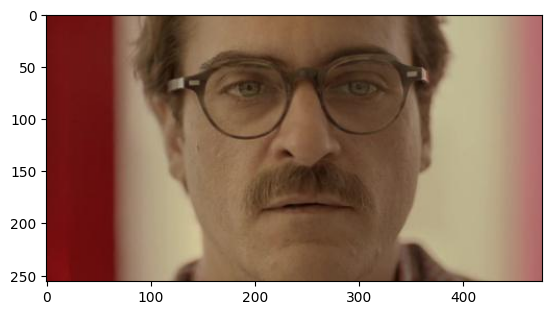

In [23]:
plt.imshow(faces_list[0])

Now that the faces have been detected, we can group them using unsupervised learning.

In [29]:
# Load the serialized face encodings + bounding box locations from
# disk, then extract the set of encodings to so we can cluster on them
encodings_path = str("../" + path_encodings + file_name)
print("Loading encodings at", encodings_path, "...")
data = pickle.loads(open(encodings_path, "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]

Loading encodings at ../raw_data/deep_face_encodings/Her (2013)/Her (2013).pickle ...


In [30]:
# Cluster the embeddings
print("Clustering...")

clt = DBSCAN(metric="euclidean", n_jobs=-1)
clt.fit(encodings)

# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])

print("Number of unique faces: {}".format(numUniqueFaces))

Clustering...
Number of unique faces: 7


In [45]:
grouped_faces = []

# Loop over the unique face integers
for labelID in labelIDs:
    # Find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes from the set
    idxs = np.where(clt.labels_ == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)), replace=False)

    # initialize the list of faces to include in the montage
    faces = []

    # loop over the sampled indexes
    for i in idxs:
        # Load the input image from Google Cloud Storage and extract the face ROI
        blob = client.bucket(bucket_name).blob(data[i]["imagePath"])
        image_bytes = blob.download_as_string()
        nparr = np.frombuffer(image_bytes, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        (top, right, bottom, left) = data[i]["loc"]
        face = image[top:bottom, left:right]

        # force resize the face ROI to 96x96 and then add it to the
        # faces montage list
        face = cv2.resize(face, (96, 96))
        faces.append(face)

    grouped_faces.append(faces)

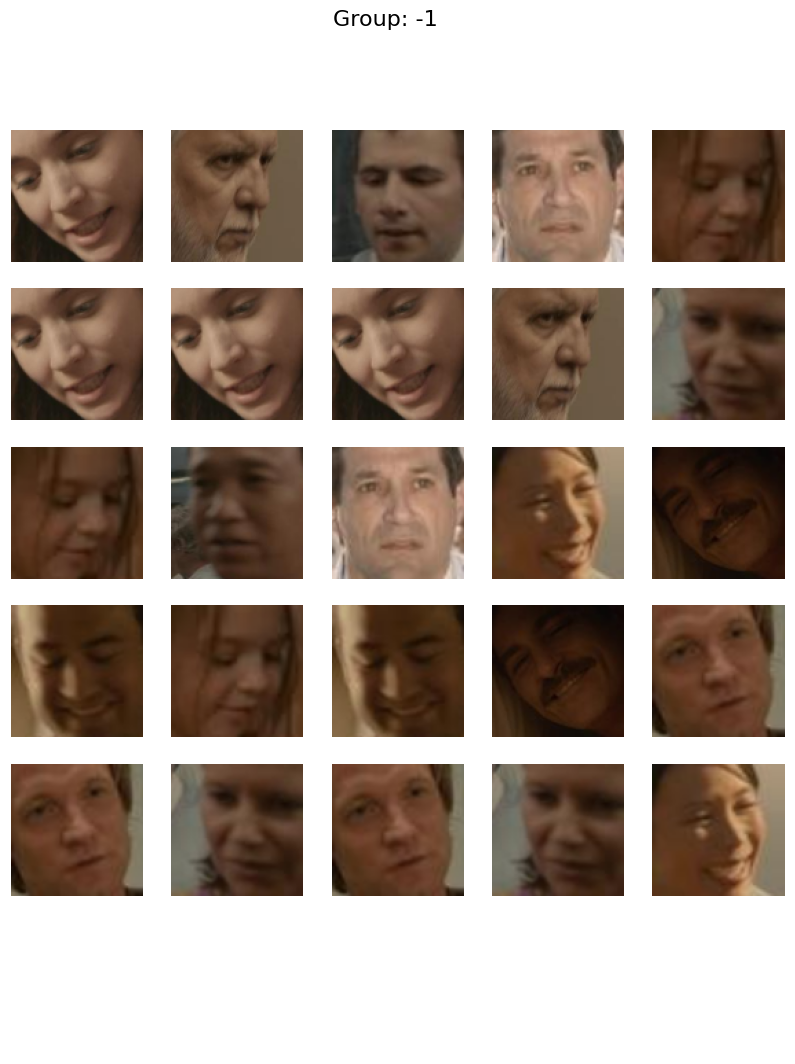

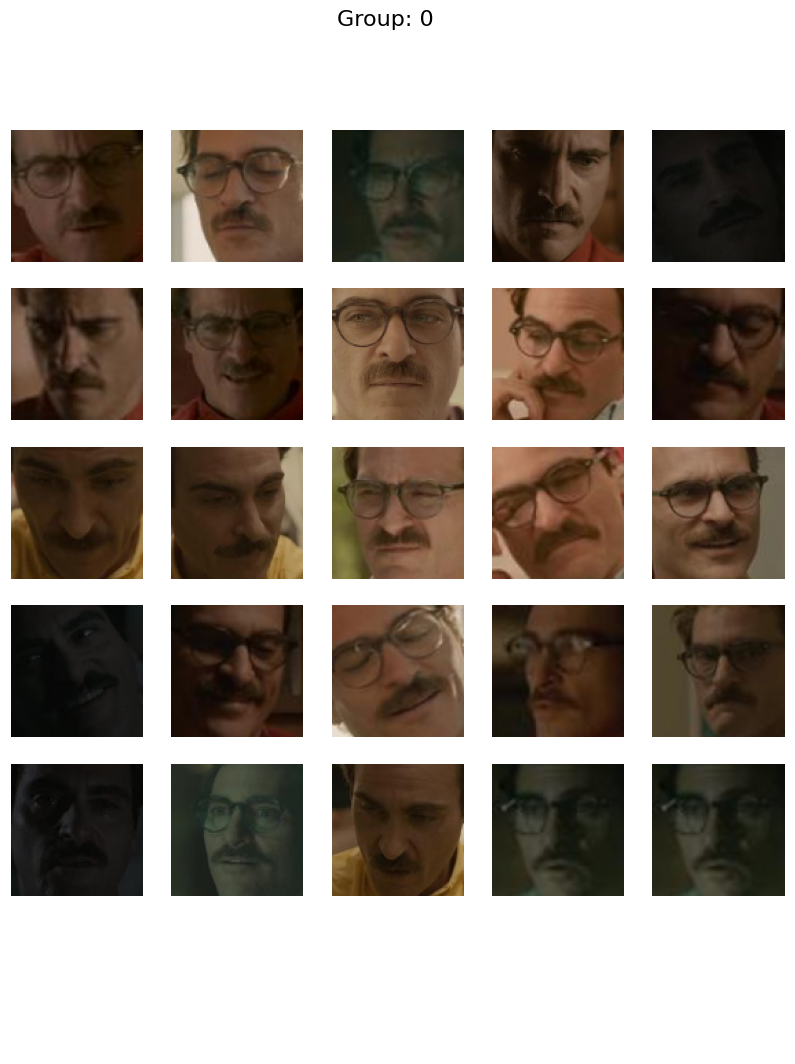

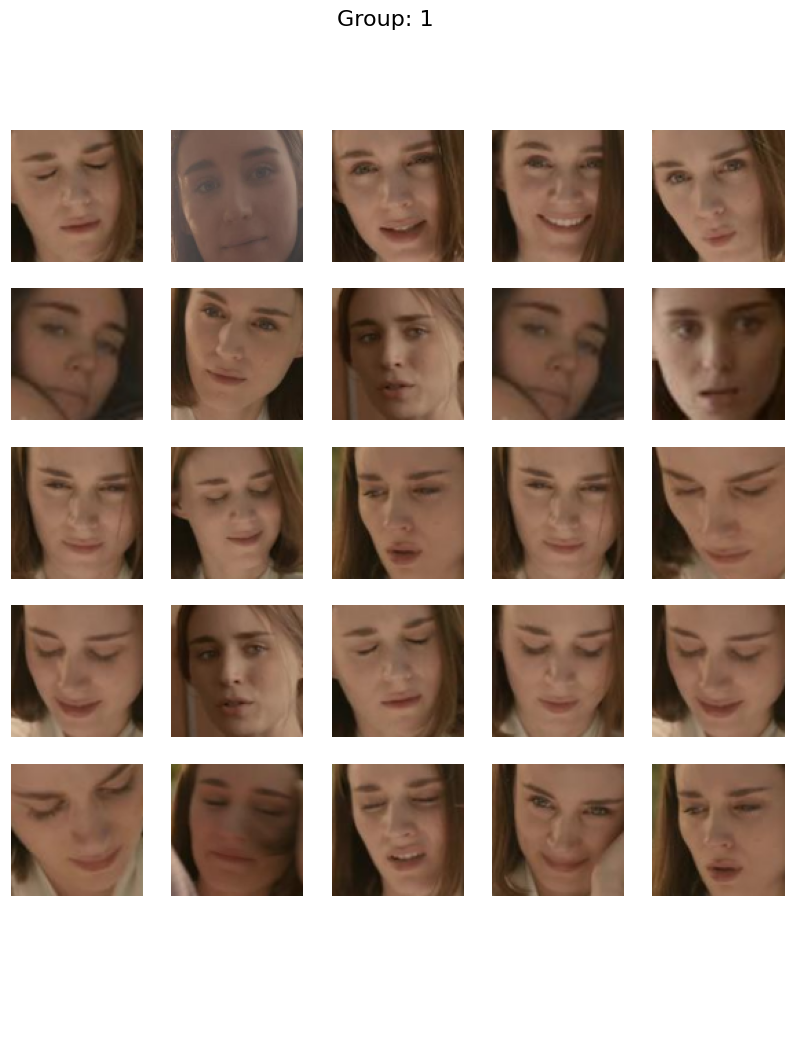

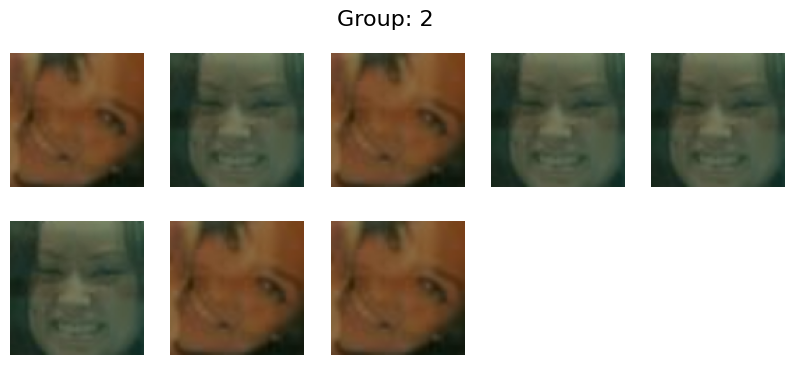

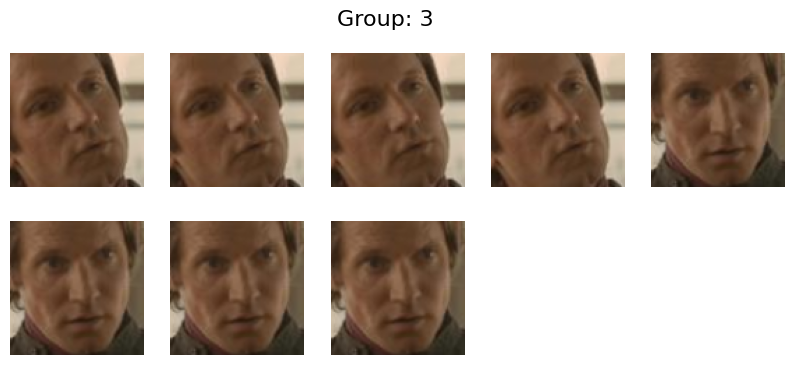

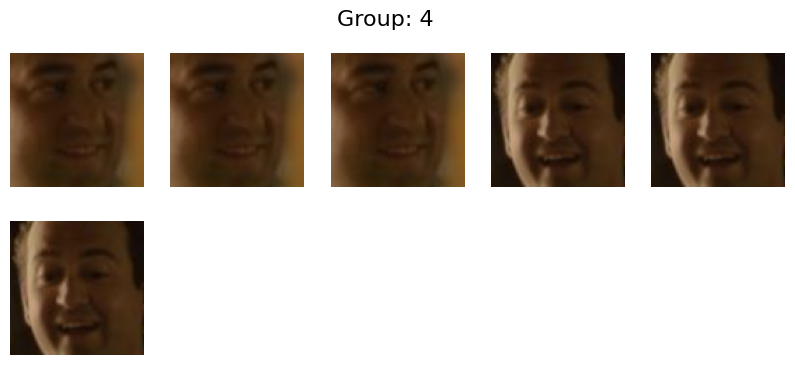

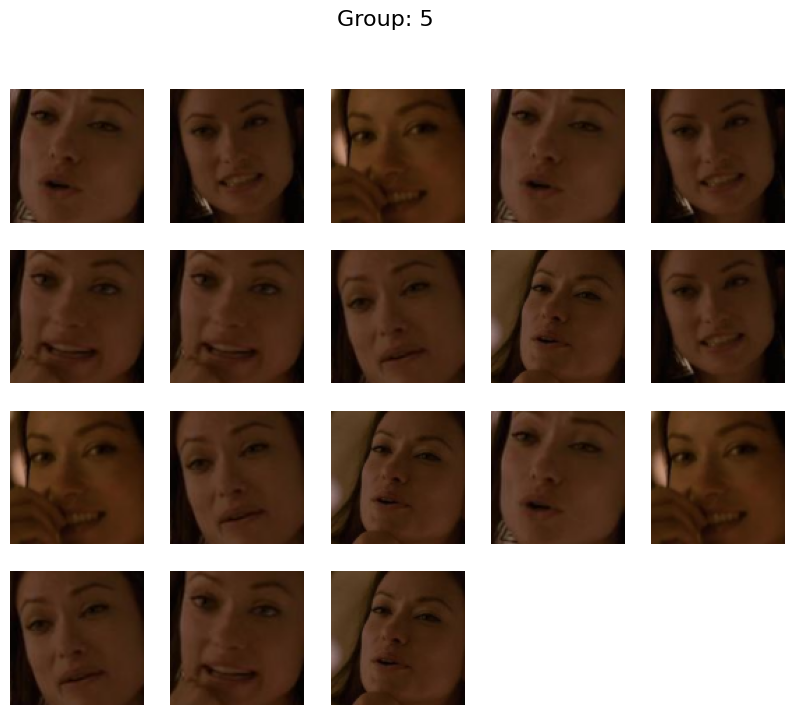

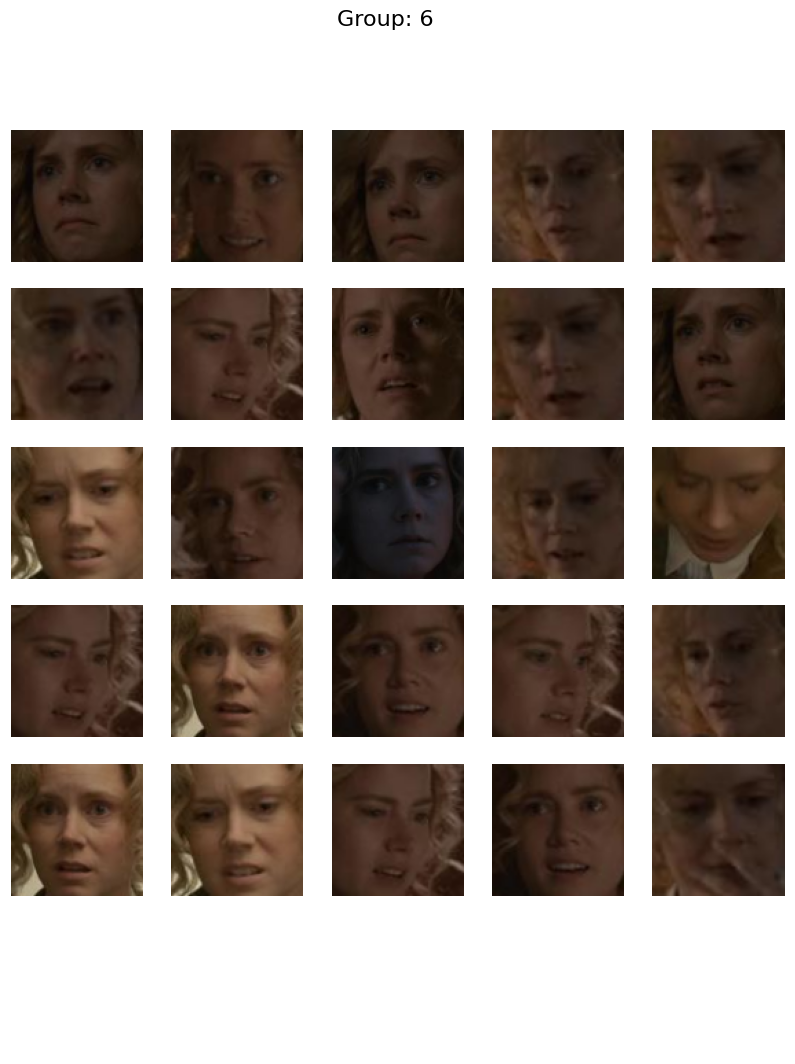

In [51]:
for group, label_name in zip(grouped_faces, labelIDs):
    num_faces = len(group)
    num_rows = (num_faces // 5) + 1  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, 5, figsize=(10, 2*num_rows))
    fig.suptitle(f"Group: {label_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < num_faces:
            ax.imshow(cv2.cvtColor(group[i], cv2.COLOR_BGR2RGB))
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axis for empty subplot

    plt.show()